In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import dataset
sales = pd.read_csv('dataset/product_sales.csv')

# Explore dataset
print(sales.info(), sales.describe())
sales.head()

# the data types are in accordance to given description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB
None                week       nb_sold       revenue  years_as_customer  \
count  15000.000000  15000.000000  13926.000000       15000.000000   
mean       3.098267     10.084667     93.934943           4.965933   
std        1.656420      1.812213     47.435312           5.044952   
min        1.000000      7.000000     32.540000           0.000

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


In [2]:
# DATA VALIDATING

## week column - the product was launched 6 weeks ago, so there should be values 1-6 - True
print('week:')
print(sales['week'].value_counts())

## sales_method - there should be only 3 unique values - there are 5
print('sales_method:')
print(sales['sales_method'].value_counts())

## customer_id - there should be unique values - True
print('customer_id:')
print(sales['customer_id'].nunique())

## nb_sold - values should be >= 0 - True 
print('nb_sold:')
print(sales[sales['nb_sold'] >= 0]['customer_id'].nunique())

## revenue - values should be >= 0 - True
print('revenue:')
print(sales[sales['revenue'] >= 0]['customer_id'].nunique())

## years_as_customer - the company was founded in 1984 (it has been there 40 years), but there are 2 entities which are customers for more than 40 years - they need to be deleted
print('years_as_customer:')
sales['years_as_customer'].value_counts().reset_index().sort_values('years_as_customer', ascending=False)

## nb_site_visits - values should be >= 0 - True
print('nb_site_visits:')
print(sales[sales['nb_site_visits'] >= 0]['customer_id'].nunique())

## state - number of unique values should be less than 50
print('state:')
print(sales['state'].nunique() <= 50)
print(sales['state'].unique())


week:
week
1    3721
4    2575
5    2574
2    2491
3    2411
6    1228
Name: count, dtype: int64
sales_method:
sales_method
Email           7456
Call            4962
Email + Call    2549
em + call         23
email             10
Name: count, dtype: int64
customer_id:
15000
nb_sold:
15000
revenue:
13926
years_as_customer:
nb_site_visits:
15000
state:
True
['Arizona' 'Kansas' 'Wisconsin' 'Indiana' 'Illinois' 'Mississippi'
 'Georgia' 'Oklahoma' 'Massachusetts' 'Missouri' 'Texas' 'New York'
 'Maryland' 'California' 'Tennessee' 'Pennsylvania' 'North Dakota'
 'Florida' 'Michigan' 'North Carolina' 'Hawaii' 'Colorado' 'Louisiana'
 'Virginia' 'New Mexico' 'Arkansas' 'Alaska' 'Oregon' 'New Hampshire'
 'Ohio' 'New Jersey' 'Connecticut' 'Iowa' 'Montana' 'Washington'
 'Kentucky' 'Alabama' 'Nebraska' 'South Carolina' 'Minnesota'
 'South Dakota' 'Delaware' 'Maine' 'Utah' 'West Virginia' 'Vermont'
 'Rhode Island' 'Nevada' 'Idaho' 'Wyoming']


In [3]:
# DATA CLEANING

# 1. Change typos in 'sales_method', so the column contains only three unique values: "Email", "Call" and "Email + Call".
sales['sales_method'] = sales['sales_method'].replace({
    'email': 'Email',
    'em + call': 'Email + Call'
})

# Check the column
sales['sales_method'].value_counts()

sales_method
Email           7466
Call            4962
Email + Call    2572
Name: count, dtype: int64

In [4]:
# 2. Company started in 1984, so maximum possible value for `years_as_customer` is the current year minus 1984 -> 40
import datetime
current_year = datetime.datetime.now().year
max_years_as_customer = current_year - 1984

sales = sales[sales['years_as_customer'] <= max_years_as_customer]

In [5]:
# 3. Checking for missing values
print(sales.isna().sum())

# There are 1074 NAs in revenue column - check if it's over 5 % of total values
threshold = len(sales) * 0.05
is_over_5pct = sales['revenue'].isna().sum() > threshold
print(is_over_5pct)

# There are more than 5 % of NAs in revenue column -> we should fill in the missing values

week                    0
sales_method            0
customer_id             0
nb_sold                 0
revenue              1074
years_as_customer       0
nb_site_visits          0
state                   0
dtype: int64
True


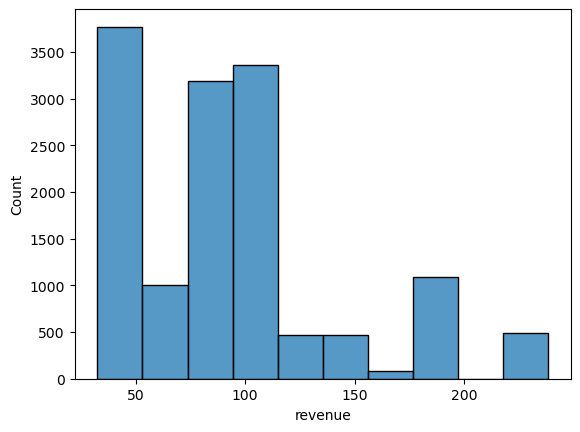

In [6]:
# Let's explore the revenue distribution 
sns.histplot(data=sales, x='revenue', bins=10)
plt.show()

# We'll use median to fill the missing values since the distribution is skewed

In [7]:
# Calculate the median revenue for each combination of sales_method and nb_sold
median_revenue = sales.groupby(['sales_method', 'nb_sold'])['revenue'].median().reset_index()

# Merge the median revenue back into the original data to align with missing values
sales = pd.merge(sales, median_revenue, on=['sales_method', 'nb_sold'], how='left', suffixes=('', '_median'))

# Fill in missing revenue values with the calculated median
sales['revenue'] = sales['revenue'].fillna(sales['revenue_median'])

# Drop the 'revenue_median' column used for the median as we don't need it anymore
sales.drop(columns=['revenue_median'], inplace=True)

# Verify that there are no more missing values in the revenue column
print(sales.isna().sum())

week                 0
sales_method         0
customer_id          0
nb_sold              0
revenue              0
years_as_customer    0
nb_site_visits       0
state                0
dtype: int64


sales_method
Call            4961
Email           7465
Email + Call    2572
Name: customer_id, dtype: int64


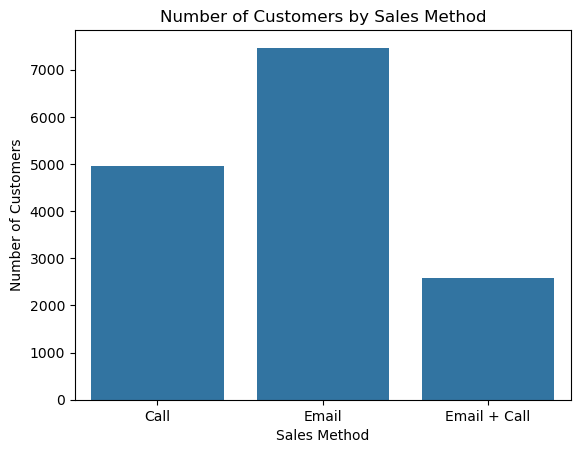

In [8]:
# ANSWERING QUESTIONS

# 1. How many customers were there for each approach?

# Count the number of unique customers per sales_method
customer_counts = sales.groupby('sales_method')['customer_id'].nunique()
print(customer_counts)

# Visualize it using bar plot
customers_plot = sns.barplot(data=customer_counts)
plt.xlabel('Sales Method')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Sales Method')
plt.show()
barplot = customers_plot.get_figure()
barplot.savefig('customers_by_sales_method.png')

count    14998.000000
mean        95.714514
std         48.386338
min         32.540000
25%         52.760000
50%         90.000000
75%        108.350000
max        238.320000
Name: revenue, dtype: float64


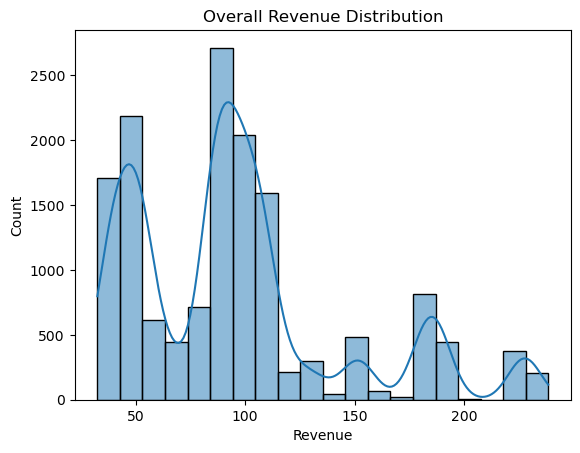

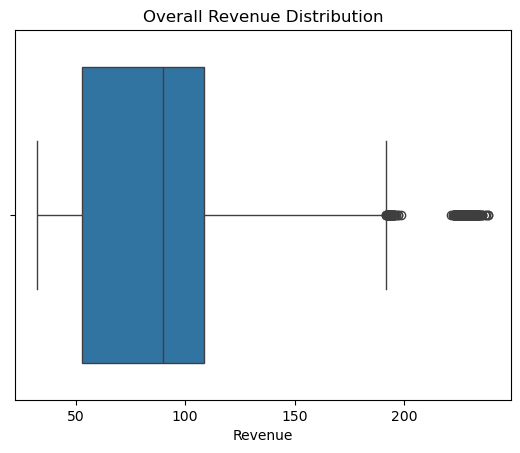

In [9]:
# 2. What does the spread of the revenue look like overall? And for each method?

# Overall revenue spread
overall_revenue_stats = sales['revenue'].describe()
print(overall_revenue_stats)

overall_revenue_hist = sns.histplot(data=sales, x='revenue', bins=20, kde=True)
plt.title('Overall Revenue Distribution')
plt.xlabel('Revenue')
plt.show()
overall_revenue_hist.get_figure().savefig('overall_revenue_hist.png')

overall_revenue_box = sns.boxplot(data=sales, x='revenue')
plt.title('Overall Revenue Distribution')
plt.xlabel('Revenue')
plt.show()
overall_revenue_box.get_figure().savefig('overall_revenue_box.png')

               count        mean        std     min       25%     50%  \
sales_method                                                            
Call          4961.0   47.640571   8.612959   32.54   41.4600   49.26   
Email         7465.0   97.165887  11.180835   78.83   88.1500   95.79   
Email + Call  2572.0  184.229413  29.106154  122.11  156.0275  184.50   

                  75%     max  
sales_method                   
Call           52.700   71.36  
Email         105.300  148.97  
Email + Call  191.275  238.32  


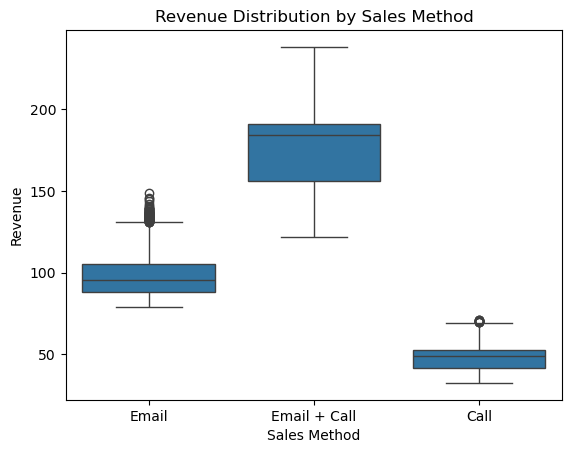

In [10]:
# Revenue spread for each method

method_revenue_stats = sales.groupby('sales_method')['revenue'].describe()
print(method_revenue_stats)

revenue_by_method = sns.boxplot(data=sales, x='sales_method', y='revenue')
plt.title('Revenue Distribution by Sales Method')
plt.xlabel('Sales Method')
plt.ylabel('Revenue')
plt.show()
revenue_by_method.get_figure().savefig('revenue_by_method_box.png')

    week  sales_method  revenue
0      1          Call   35.150
1      1         Email   86.650
2      1  Email + Call  128.785
3      2          Call   43.500
4      2         Email   99.430
5      2  Email + Call  153.780
6      3          Call   41.455
7      3         Email   91.735
8      3  Email + Call  150.340
9      4          Call   51.340
10     4         Email  108.340
11     4  Email + Call  181.020
12     5          Call   53.010
13     5         Email  108.350
14     5  Email + Call  187.190
15     6          Call   65.885
16     6         Email  129.910
17     6  Email + Call  227.265


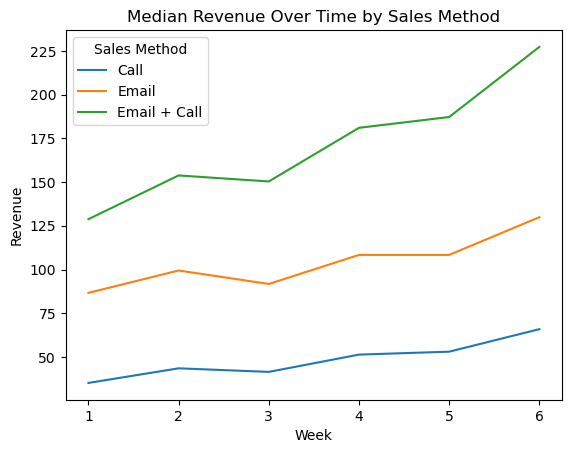

In [11]:
# 3. Was there any difference in revenue over time for each of the methods?

# Group by week and sales_method to see the revenue trend over time
revenue_trend = sales.groupby(['week', 'sales_method'])['revenue'].median().reset_index()
print(revenue_trend)

# Visualize the trend
revenue_over_time = sns.lineplot(data=revenue_trend, x='week', y='revenue', hue='sales_method')
plt.title('Median Revenue Over Time by Sales Method')
plt.legend(title='Sales Method')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.show()
revenue_over_time.get_figure().savefig('revenue_over_time.png')

In [12]:
# 4. Based on the data, which method would you recommend we continue to use?

# Create column for Revenue per pcs
sales['revenue_per_unit'] = sales['revenue'] / sales['nb_sold']

# Calculate total revenue per method, avg revenue
sales_performance = sales.groupby('sales_method').agg(
    total_revenue=('revenue', 'sum'),
    median_revenue=('revenue', 'median'),
    avg_revenue_per_unit=('revenue_per_unit', 'mean'),
    nb_customers=('customer_id', 'nunique')
).reset_index()
print(sales_performance)
sales_performance.to_csv('sales_performance.csv')

   sales_method  total_revenue  median_revenue  avg_revenue_per_unit  \
0          Call     236344.875           49.26              5.013670   
1         Email     725343.350           95.79              9.999542   
2  Email + Call     473838.050          184.50             15.073800   

   nb_customers  
0          4961  
1          7465  
2          2572  


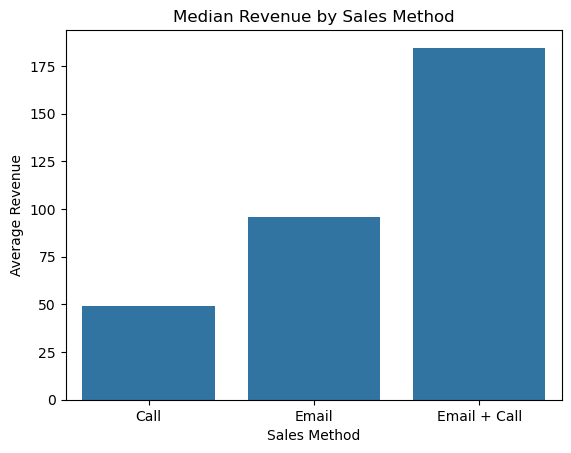

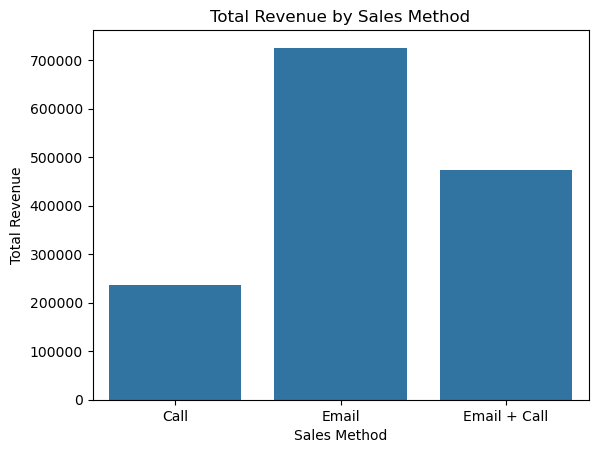

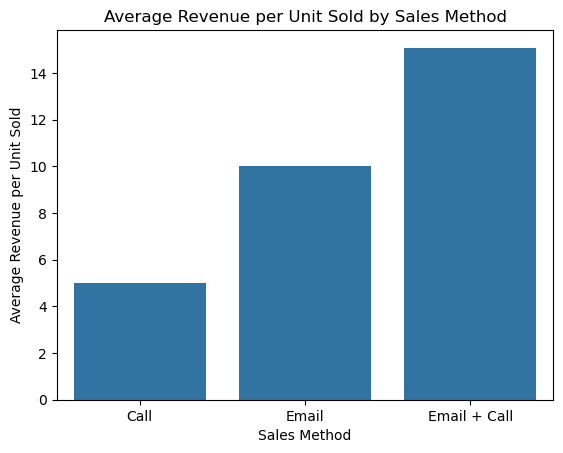

In [13]:
# Visualize Median Revenue by Sales Method
sns.barplot(data=sales_performance, x='sales_method', y='median_revenue')
plt.title('Median Revenue by Sales Method')
plt.xlabel('Sales Method')
plt.ylabel('Average Revenue')
plt.show()

# Visualize Total Revenue by Sales Method
sns.barplot(data=sales_performance, x='sales_method', y='total_revenue')
plt.title('Total Revenue by Sales Method')
plt.xlabel('Sales Method')
plt.ylabel('Total Revenue')
plt.show()

# Visualize and save Average Revenue per Unit Sold by Sales Method
avg_revenue_per_pcs = sns.barplot(data=sales_performance, x='sales_method', y='avg_revenue_per_unit')
plt.title('Average Revenue per Unit Sold by Sales Method')
plt.xlabel('Sales Method')
plt.ylabel('Average Revenue per Unit Sold')
plt.show()
avg_revenue_per_pcs.get_figure().savefig('avg_revenue_per_pcs.png')

    sales_method  week  avg_revenue_per_unit
0           Call     1              4.995993
1           Call     2              4.958186
2           Call     3              5.058569
3           Call     4              5.044900
4           Call     5              4.991392
5           Call     6              5.034804
6          Email     1             10.041558
7          Email     2              9.955230
8          Email     3             10.005447
9          Email     4              9.970307
10         Email     5              9.965129
11         Email     6              9.988042
12  Email + Call     1             14.926224
13  Email + Call     2             15.281435
14  Email + Call     3             15.034376
15  Email + Call     4             15.050790
16  Email + Call     5             15.041043
17  Email + Call     6             15.128067


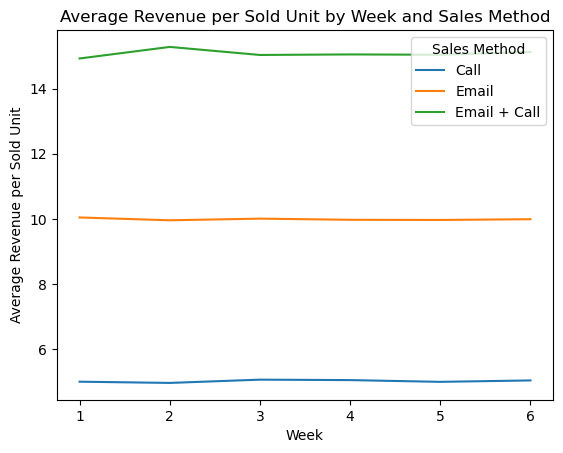

In [15]:
# METRIC DEFINITION FOR BUSINESS MONITORING

# How should the business monitor what they want to achieve?
## Group by week and sales_method to see the revenue per unit trend over time
metric_week = sales.groupby(['sales_method', 'week']).agg(
    avg_revenue_per_unit=('revenue_per_unit', 'mean')
).reset_index()
print(metric_week)

# Visualize and save Average Revenue per Sold Unit by Week and Sales Method
avg_revenue_per_unit_by_week = sns.lineplot(data=metric_week, x='week', y='avg_revenue_per_unit', hue='sales_method')
plt.title('Average Revenue per Sold Unit by Week and Sales Method')
plt.xlabel('Week')
plt.ylabel('Average Revenue per Sold Unit')
plt.legend(title='Sales Method')
plt.show()
avg_revenue_per_unit_by_week.get_figure().savefig('avg_revenue_per_unit_by_week.png')

In [16]:
# Estimate the initial value(s) for the metric based on the current data
## Group by sales method to find the average revenue per unit sold for each method
metric_week_initial_value = sales.groupby('sales_method')['revenue_per_unit'].mean().reset_index()
metric_week_initial_value

,sales_method,revenue_per_unit
0,Call,5.013670
1,Email,9.999542
2,Email + Call,15.073800


Customer Distribution by State and Sales Method:
 sales_method    Call  Email  Email + Call
state                                    
Alabama           63    112            39
Alaska            13     21             6
Arizona          117    147            57
Arkansas          51     59            22
California       641    920           309
Colorado          72    122            36
Connecticut       60     78            41
Delaware           9     17             8
Florida          297    452           155
Georgia          153    257            79
Hawaii            24     34            14
Idaho             15     34            13
Illinois         210    313            94
Indiana          108    189            57
Iowa              53     90            22
Kansas            46     73            23
Kentucky          75     98            40
Louisiana         74    115            41
Maine             26     30             7
Maryland          89    131            43
Massachusetts     95    14

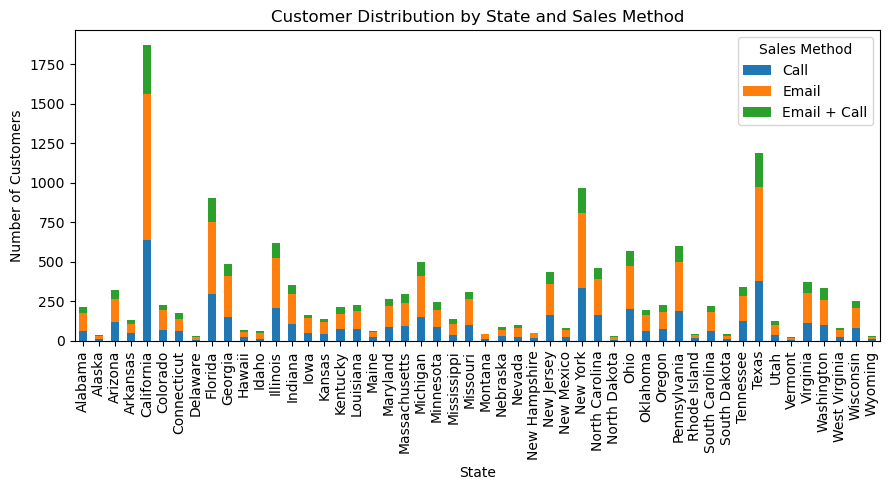

In [18]:
# 5. The company doesn’t really know if there are other differences between the customers in each group, so
#any information would be really helpful to give some context to what went well.

# Customer concentration by state and sales method
customer_distribution = sales.groupby(['state', 'sales_method'])['customer_id'].nunique().unstack(fill_value=0)
print("Customer Distribution by State and Sales Method:\n", customer_distribution)

# Stacked Bar Plot of customer_distribution
distribution_by_state = customer_distribution.plot(kind='bar', stacked=True, figsize=(9, 5))
plt.title('Customer Distribution by State and Sales Method')
plt.ylabel('Number of Customers')
plt.xlabel('State')
plt.xticks(rotation=90)
plt.legend(title='Sales Method')
plt.tight_layout()
plt.show()
distribution_by_state.get_figure().savefig('distribution_by_state.png')